In [67]:
#%pip install boruta scikit-learn pandas
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from collections import Counter
from itertools import chain
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from scipy.stats import wilcoxon
import math
from functools import reduce

## Import and Preprocess the Data 

In [70]:
#Load all the data and load differentially expressed genes

RNA_seq_all = pd.read_csv("Human RNA-seq data (Entrez).csv")
DEG = pd.read_csv ("Differentially expressed genes mucosal RNAseq - week 4 vs baseline.csv")

In [72]:
RNA_seq_all.shape

(10809, 31)

In [74]:
RNA_seq_all.head()

,Entrez(Gene)_ID,1A,2A,3A,4A,5A,6A,7A,8A,9A,...,6C,7C,8C,9C,10C,11C,12C,13C,14C,15C
0,4537,135728,92648,40999,83165,74651,49557,113780,43080,141625,...,85610,122421,132901,155220,137239,159596,218583,109955,186650,138957
1,4514,183379,96665,129423,43053,42441,22386,63152,35268,76462,...,42836,69945,98498,79920,102721,125070,140860,78147,120631,105546
2,4538,182181,100599,102847,53057,56973,26450,59561,28282,74868,...,42991,61064,73256,85586,78720,124370,136441,71421,131616,87300
3,378938,92928,41778,48657,65542,44115,46642,39790,43710,66385,...,63077,75206,79614,83127,143223,96500,82050,97327,115287,50618
4,4508,115178,63129,66531,33137,35960,17751,41965,21607,47806,...,33891,49221,61534,65957,81328,80031,107271,56244,72387,64958


In [76]:
DEG.head()

,EntrezID,logFC,logCPM,LR,PValue,FDR,gene,description
0,54979,-6.368227,3.452422,35.348679,2.760000e-09,8.790000e-07,PLAAT2,phospholipase A and acyltransferase 2 [Source:...
1,55218,-3.446965,3.803808,14.315079,1.546210e-04,8.424146e-03,EXD2,exonuclease 3'-5' domain containing 2 [Source:...
2,646625,-3.128449,4.703188,18.758626,1.480000e-05,1.398626e-03,URAD,ureidoimidazoline (2-oxo-4-hydroxy-4-carboxy-5...
3,405753,-2.990519,6.148583,43.539044,4.160000e-11,1.800000e-08,DUOXA2,dual oxidase maturation factor 2 [Source:HGNC ...
4,54970,-2.906858,3.232868,5.690110,1.706079e-02,1.808143e-01,TTC12,tetratricopeptide repeat domain 12 [Source:HGN...


In [78]:
DEG.shape

(1104, 8)

In [80]:
# Your list of target genes
target_genes = ['ADAMDEC1', 'AHNAK', 'AXL', 'CXCL14', 'FBLN1', 'FHL1', 
                'GPR155', 'MYADM', 'OAT', 'SPEN', 'TCF4', 'ZBTB20', 'ZNF830']

# Filter rows where the gene column matches any of the target genes
filtered_DEG = DEG[DEG['gene'].isin(target_genes)]

# Display gene and corresponding EntrezID
print(filtered_DEG[['gene', 'EntrezID']])

          gene  EntrezID
287      AHNAK     79026
339     ZBTB20     26137
346      MYADM     91663
357       SPEN     23013
427       TCF4      6925
507     CXCL14      9547
587   ADAMDEC1     27299
705        AXL       558
727      FBLN1      2192
861        OAT      4942
867     GPR155    151556
1050    ZNF830     91603
1082      FHL1      2273


In [82]:
#left join the DEG with RNA_SEQ data AND make gene as index and drop Entrez ID

# Step 1: Ensure key columns match
# Rename 'Entrez(Gene)_ID' in RNA_seq_all to match 'EntrezID' in DEG
RNA_seq_all_renamed = RNA_seq_all.rename(columns={'Entrez(Gene)_ID': 'EntrezID'})

# Step 2: Perform left join
merged = DEG.merge(RNA_seq_all_renamed, on='EntrezID', how='left')

# Step 3: Remove unwanted coloumns 
merged = merged.drop(['logFC', 'logCPM', 'LR', 'PValue', 'FDR', 'description'], axis = 1)

# Step 4: make the gene as index and remove EntrezID
merged = merged.set_index('gene').drop(columns='EntrezID')

In [84]:
merged.shape

(1104, 30)

In [86]:
#Transpose 

merged_df = merged.T
merged_df.index.name = 'Sample_ID'

In [88]:
missings = merged_df.isna().sum()
missings = missings[missings > 0]

print (missings)

gene
MUC5AC     30
FKBP7      30
NUMBL      30
BICC1      30
SLC9A9     30
TLR7       30
PCSK9      30
HERC5      30
C3orf62    30
ADRB2      30
SLC7A2     30
NCF1C      30
FLT3LG     30
ZSCAN32    30
TCF21      30
SIGLEC6    30
dtype: int64


In [90]:
# Drop columns with missing values 

merged_df_clean = merged_df.dropna(axis=1)

In [92]:
merged_df_clean.isna().any().sum()

0

In [94]:
merged_df_clean.head(30)

gene,PLAAT2,EXD2,URAD,DUOXA2,TTC12,MYOM3,RSAD2,CASP5,TNFRSF6B,TNS4,...,CFL2,PDE1A,ADAMTS1,FOLR2,PTGS2,EFEMP1,TIGD5,BNIP1,OLFML3,RAB34
Sample_ID,,,,,,,,,,,,,,,,,,,,,
1A,20.0,141.0,63.0,0.0,0.0,4.0,0.0,145.0,0.0,8.0,...,1.0,0.0,107.0,0.0,0.0,0.0,50.0,4.0,0.0,45.0
2A,17.0,57.0,32.0,91.0,50.0,9.0,41.0,24.0,5.0,7.0,...,0.0,0.0,0.0,1.0,0.0,50.0,0.0,0.0,1.0,0.0
3A,50.0,40.0,169.0,750.0,1.0,84.0,66.0,1449.0,278.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4A,0.0,96.0,49.0,331.0,137.0,12.0,21.0,270.0,136.0,0.0,...,96.0,0.0,0.0,88.0,29.0,1.0,0.0,0.0,0.0,0.0
5A,31.0,83.0,17.0,334.0,28.0,66.0,0.0,150.0,86.0,26.0,...,35.0,0.0,0.0,0.0,2.0,0.0,54.0,14.0,0.0,0.0
6A,0.0,20.0,33.0,519.0,0.0,45.0,2.0,130.0,66.0,25.0,...,0.0,17.0,82.0,20.0,29.0,0.0,1.0,0.0,31.0,0.0
7A,12.0,48.0,56.0,0.0,41.0,90.0,47.0,67.0,0.0,0.0,...,26.0,1.0,0.0,5.0,9.0,1.0,0.0,0.0,0.0,0.0
8A,51.0,47.0,89.0,110.0,0.0,11.0,0.0,158.0,33.0,23.0,...,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,144.0
9A,89.0,30.0,70.0,311.0,69.0,1.0,23.0,172.0,315.0,47.0,...,0.0,0.0,1.0,0.0,0.0,38.0,70.0,2.0,0.0,25.0


In [96]:
#Create Timepoint coloumn 

merged_df_clean['Timepoint'] = merged_df_clean.index.map(lambda x: 'Baseline' if x.endswith('A') else 'Week 4')

/var/folders/0_/qg07x0dd5s5dkp59h7mxv64h0000gn/T/ipykernel_3595/4186238040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['Timepoint'] = merged_df_clean.index.map(lambda x: 'Baseline' if x.endswith('A') else 'Week 4')


In [98]:
#create x and y where x contain the expression and y the timepoint only 

X = merged_df_clean.drop(columns = ["Timepoint"])
y = merged_df_clean['Timepoint']

In [100]:
#Normalize the data 

X_log = np.log1p(X)

In [102]:
X_log.head()

gene,PLAAT2,EXD2,URAD,DUOXA2,TTC12,MYOM3,RSAD2,CASP5,TNFRSF6B,TNS4,...,CFL2,PDE1A,ADAMTS1,FOLR2,PTGS2,EFEMP1,TIGD5,BNIP1,OLFML3,RAB34
Sample_ID,,,,,,,,,,,,,,,,,,,,,
1A,3.044522,4.955827,4.158883,0.000000,0.000000,1.609438,0.000000,4.983607,0.000000,2.197225,...,0.693147,0.0,4.682131,0.000000,0.000000,0.000000,3.931826,1.609438,0.000000,3.828641
2A,2.890372,4.060443,3.496508,4.521789,3.931826,2.302585,3.737670,3.218876,1.791759,2.079442,...,0.000000,0.0,0.000000,0.693147,0.000000,3.931826,0.000000,0.000000,0.693147,0.000000
3A,3.931826,3.713572,5.135798,6.621406,0.693147,4.442651,4.204693,7.279319,5.631212,3.850148,...,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000
4A,0.000000,4.574711,3.912023,5.805135,4.927254,2.564949,3.091042,5.602119,4.919981,0.000000,...,4.574711,0.0,0.000000,4.488636,3.401197,0.693147,0.000000,0.000000,0.000000,0.000000
5A,3.465736,4.430817,2.890372,5.814131,3.367296,4.204693,0.000000,5.017280,4.465908,3.295837,...,3.583519,0.0,0.000000,0.000000,1.098612,0.000000,4.007333,2.708050,0.000000,0.000000


In [104]:
# Scale x before PCA 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

## Perform PCA with ellipses covering 95% CI


In [107]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X_scaled)

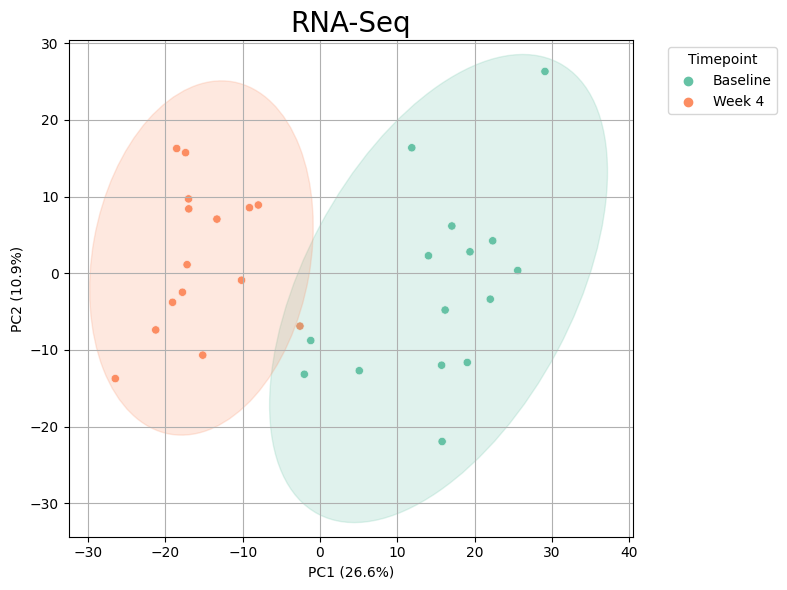

In [109]:
#Plot PCA with ellipses covering 95% CI

# Helper function to draw ellipse
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        scale_factor = np.sqrt(chi2.ppf(0.95, df=2))  # ~2.4477
        width, height = 2 * scale_factor * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(xy=position, width = width, height = height, angle = angle, **kwargs)
    ax.add_patch(ellipse)

# Step 1: Create PCA result DataFrame
pca_df = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=y.index)

# Step 2: Add Timepoint metadata
pca_df['Timepoint'] = merged_df_clean['Timepoint']

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Timepoint', palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df['Timepoint'].unique()):
    group = pca_df[pca_df['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("RNA-Seq", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('PCA_rnasq.png')
plt.show()

## LASSO With LOOCV 

In [112]:

#Preprocess y to be 0 baseline and 1 for week 4

# Convert 'Baseline' → 0 and 'Week 4' → 1
y = y.map({'Baseline': 0, 'Week 4': 1})

In [114]:
y.head()

Sample_ID
1A    0
2A    0
3A    0
4A    0
5A    0
Name: Timepoint, dtype: int64

In [116]:
n_patients = 15
y_true_LA = []
y_pred_prob_LA = []
selected_genes_list_LA = []
auc_per_fold = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ✅ Apply log1p transformation after the split
    X_train = np.log1p(X_train_raw)
    X_test = np.log1p(X_test_raw)

    # Inner loop for lambda selection
    inner_model_LA = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[1.0],
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1,
        random_state=42
    )

    pipeline_LA = make_pipeline(StandardScaler(), inner_model_LA)
    pipeline_LA.fit(X_train, y_train)

    # Get best parameters
    best_C_LA = inner_model_LA.C_[0]
    best_l1_ratio_LA = inner_model_LA.l1_ratio_[0]

    # Retrain final model on full training fold with best parameters
    final_model_LA = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_LA,
            l1_ratio=best_l1_ratio_LA,
            solver='saga',
            max_iter=10000,
            random_state=42
        )
    )
    final_model_LA.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_LA = final_model_LA.predict_proba(X_test)[:, 1]
    y_pred_prob_LA.extend(y_prob_LA)
    y_true_LA.extend(y_test.tolist())
    
    # ✅ Compute and store AUC for this fold
    auc_fold = roc_auc_score(y_test, y_prob_LA)
    auc_per_fold.append(auc_fold)
    
    # Get selected features
    coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
    selected_genes_LA = X.columns[coefs_LA != 0]
    selected_genes_list_LA.append(selected_genes_LA.tolist())

In [117]:
#Model Evaluation Metrics

y_pred_label_LA = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_LA]

# Accuracy
acc_LA = accuracy_score(y_true_LA, y_pred_label_LA)

# Sensitivity (Recall for class 1)
sensitivity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=1)

# Specificity (Recall for class 0)
specificity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=0)

# F1 Score
f1_LA = f1_score(y_true_LA, y_pred_label_LA)

# AUC
auc_LA = roc_auc_score(y_true_LA, y_pred_prob_LA)


# Confusion Matrix
cm_LA = confusion_matrix(y_true_LA, y_pred_label_LA)

# Print the results
print(f"Accuracy:    {acc_LA:.3f}")
print(f"Sensitivity: {sensitivity_LA:.3f}")
print(f"Specificity: {specificity_LA:.3f}")
print(f"F1 Score:    {f1_LA:.3f}")
print(f"AUC:         {auc_LA:.3f}")
print("Confusion Matrix:")
print(cm_LA)

Accuracy:    0.933
Sensitivity: 1.000
Specificity: 0.867
F1 Score:    0.938
AUC:         0.964
Confusion Matrix:
[[13  2]
 [ 0 15]]


In [118]:
auc_per_fold

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Number of consistently selected genes across all patients: 17


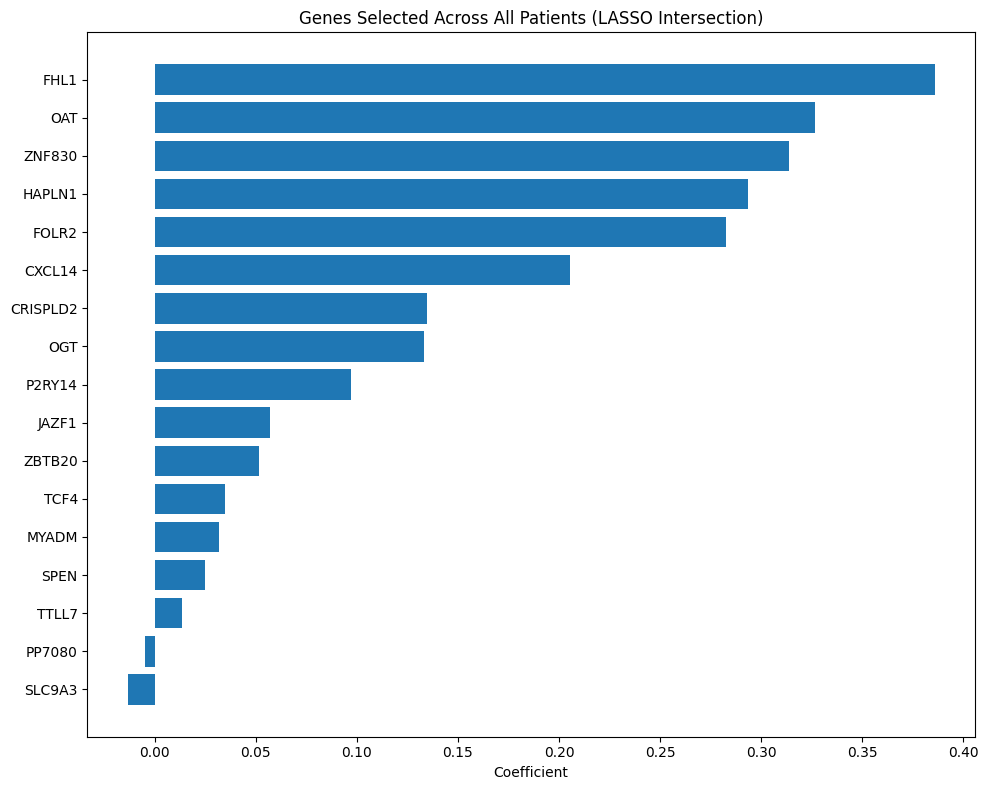

In [126]:
# Step 1: Find intersected genes across all patients
intersected_genes = list(reduce(lambda x, y: set(x) & set(y), selected_genes_list_LA))
print(f"Number of consistently selected genes across all patients: {len(intersected_genes)}")

# Step 2: Extract coefficients from the last trained final_model_LA
coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
feature_names = X.columns

# Step 3: Create DataFrame of all coefficients
coef_df = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_LA
})

# Step 4: Filter to only the intersected genes
intersected_df = coef_df[
    (coef_df['Gene'].isin(intersected_genes)) &
    (abs(coef_df['Coefficient']) > 1e-6)
].sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.barh(intersected_df['Gene'], intersected_df['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Genes Selected Across All Patients (LASSO Intersection)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [120]:
intersected_df.head(17)

,Gene,Coefficient
1069,FHL1,0.385826
860,OAT,0.326710
1039,ZNF830,0.313857
1072,HAPLN1,0.293431
1081,FOLR2,0.282844
506,CXCL14,0.205300
963,CRISPLD2,0.134882
689,OGT,0.133346
1046,P2RY14,0.097282
1070,JAZF1,0.057206


## Elastic Net with LOOCV 

In [128]:
n_patients = 15
y_true_EN = []
y_pred_prob_EN = []
selected_genes_list_EN = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ✅ Apply log1p transformation after the split
    X_train = np.log1p(X_train_raw)
    X_test = np.log1p(X_test_raw)


    # Inner loop for lambda selection
    inner_model_EN = LogisticRegressionCV(
        Cs=10,                      # Number of inverse lambdas to try
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[0.5],            
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1
    )

    pipeline_EN = make_pipeline(StandardScaler(), inner_model_EN)
    pipeline_EN.fit(X_train, y_train)


        # Get best parameters
    best_C_EN = inner_model_EN.C_[0]
    best_l1_ratio_EN = inner_model_EN.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_EN = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_EN,
            l1_ratio=best_l1_ratio_EN,
            solver='saga',
            max_iter=10000
        )
    )
    final_model_EN.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_EN = final_model_EN.predict_proba(X_test)[:, 1]
    y_pred_prob_EN.extend(y_prob_EN)
    y_true_EN.extend(y_test.tolist())

    # Get selected features
    coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
    selected_genes_EN = X_log.columns[coefs_EN != 0]
    selected_genes_list_EN.append(selected_genes_EN.tolist())

In [129]:
#Model Evaluation Metrics

y_pred_label_EN = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_EN]
# Accuracy
acc_EN = accuracy_score(y_true_EN, y_pred_label_EN)

# Sensitivity (Recall for class 1)
sensitivity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=1)

# Specificity (Recall for class 0)
specificity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=0)

# F1 Score
f1_EN = f1_score(y_true_EN, y_pred_label_EN)

# AUC
auc_EN = roc_auc_score(y_true_EN, y_pred_prob_EN)

# Confusion Matrix
cm_EN = confusion_matrix(y_true_EN, y_pred_label_EN)

# Print the results
print(f"Accuracy:    {acc_EN:.3f}")
print(f"Sensitivity: {sensitivity_EN:.3f}")
print(f"Specificity: {specificity_EN:.3f}")
print(f"F1 Score:    {f1_EN:.3f}")
print(f"AUC:         {auc_EN:.3f}")
print("Confusion Matrix:")
print(cm_EN)

Accuracy:    0.933
Sensitivity: 1.000
Specificity: 0.867
F1 Score:    0.938
AUC:         0.982
Confusion Matrix:
[[13  2]
 [ 0 15]]


Number of consistently selected genes across all patients: 22


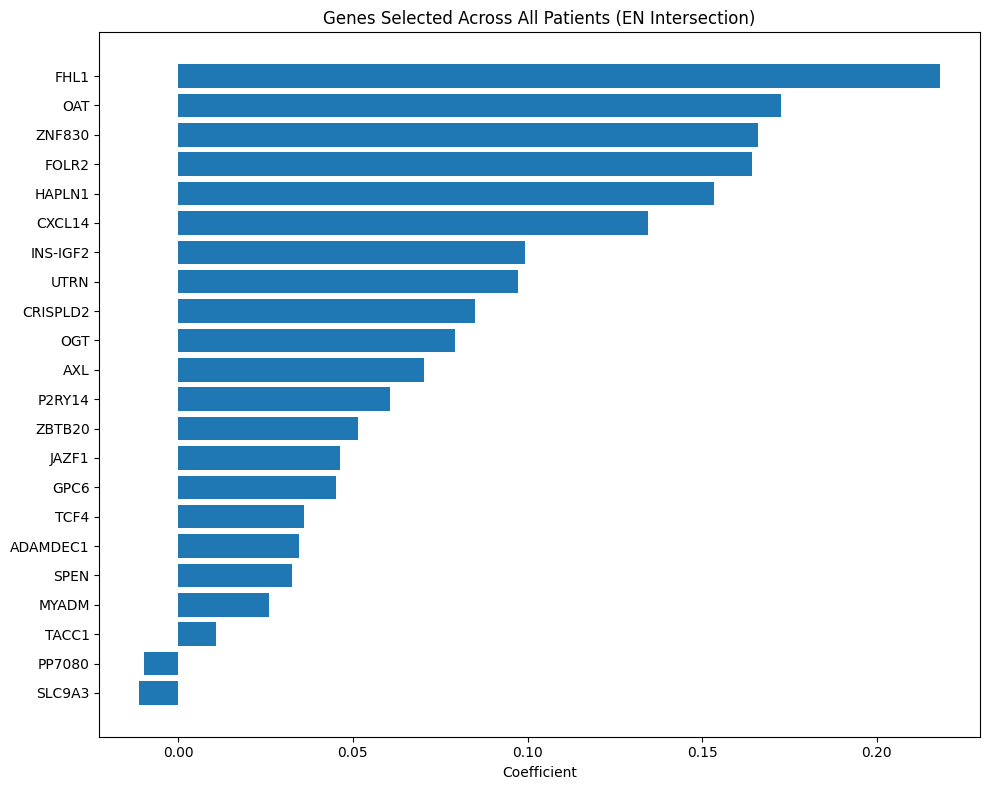

In [130]:
# Step 1: Find intersected genes across all patients
intersected_genes_EN = list(reduce(lambda x, y: set(x) & set(y), selected_genes_list_EN))
print(f"Number of consistently selected genes across all patients: {len(intersected_genes_EN)}")

# Step 2: Extract coefficients from the last trained final_model_LA
coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
feature_names = X.columns

# Step 3: Create DataFrame of all coefficients
coef_df_EN = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_EN
})

# Step 4: Filter to only the intersected genes
intersected_df_EN = coef_df_EN[
    (coef_df_EN['Gene'].isin(intersected_genes_EN)) &
    (abs(coef_df_EN['Coefficient']) > 1e-6)
].sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.barh(intersected_df_EN['Gene'], intersected_df_EN['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Genes Selected Across All Patients (EN Intersection)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Brouta + RF (Leave Pair out CV)

In [134]:
# Convert data to NumPy arrays
X = X.copy()
y = np.array(y)

n_patients = 15

# Storage
y_true_all_RF = []
y_pred_all_RF = []
y_prob_all_RF = []
selected_feature_lists = []

for i in range(n_patients):
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # ✅ Split then apply log1p
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    X_train = np.log1p(X_train_raw)
    X_test = np.log1p(X_test_raw)

    y_train, y_test = y[train_idx], y[test_idx]

    # ✅ Scale training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ✅ Feature selection with Boruta
    model_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    boruta = BorutaPy(
        estimator=model_rf,
        n_estimators='auto',
        max_iter=100,
        perc=100,
        verbose=0,
        random_state=42
    )
    boruta.fit(X_train_scaled, y_train)

    selected_idx = boruta.support_
    selected_feature_names = X.columns[selected_idx].tolist()
    selected_feature_lists.append(selected_feature_names)

    X_train_sel = boruta.transform(X_train_scaled)
    X_test_sel = boruta.transform(X_test_scaled)

    # ✅ Final model on selected features
    model_final = RandomForestClassifier(n_estimators=100, random_state=42)
    model_final.fit(X_train_sel, y_train)

    y_pred_RF = model_final.predict(X_test_sel)
    y_prob_RF = model_final.predict_proba(X_test_sel)[:, 1]

    y_true_all_RF.extend(y_test)
    y_pred_all_RF.extend(y_pred_RF)
    y_prob_all_RF.extend(y_prob_RF)

In [135]:
# Final evaluation

label_mapping = {'Baseline': 0, 'Week 2': 1}
y_true_all_RF = [label_mapping[label] for label in y_true_all_RF]
y_pred_all_RF = [label_mapping[label] for label in y_pred_all_RF]

acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)
cm_RF = confusion_matrix(y_true_all_RF, y_pred_all_RF)

acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)

print(f"\nAccuracy:    {acc_RF:.3f}")
print(f"F1 Score:    {f1_RF:.3f}")
print(f"Sensitivity: {sensitivity_RF:.3f}")
print(f"Specificity: {specificity_RF:.3f}")
print(f"AUC:         {auc_RF:.3f}")

KeyError: 0

In [131]:
#get the most selected features by brouta across each fold 

all_selected_features = list(chain.from_iterable(selected_feature_lists))

feature_counts = Counter(all_selected_features)

# Sort by most common
most_common_features = feature_counts.most_common()

print("\nMost frequently selected features across folds:")
for feature, count in most_common_features:
    print(f"{feature}: selected in {count} folds")


Most frequently selected features across folds:
ZBTB20: selected in 15 folds
MYADM: selected in 15 folds
SPEN: selected in 15 folds
PDGFRA: selected in 15 folds
TCF4: selected in 15 folds
GOLGA7: selected in 15 folds
CXCL14: selected in 15 folds
ADAMDEC1: selected in 15 folds
FN1: selected in 15 folds
CCDC80: selected in 15 folds
AXL: selected in 15 folds
MS4A7: selected in 15 folds
FBLN1: selected in 15 folds
CUTALP: selected in 15 folds
OAT: selected in 15 folds
GPR155: selected in 15 folds
FHL1: selected in 15 folds
HBB: selected in 14 folds
ZNF331: selected in 14 folds
CRIP2: selected in 13 folds
ZNF830: selected in 13 folds
NBAS: selected in 13 folds
AHNAK: selected in 12 folds
ACTA2: selected in 12 folds
RUNX1T1: selected in 12 folds
ANXA6: selected in 11 folds
PRNP: selected in 10 folds
DPY19L3: selected in 10 folds
ZEB2: selected in 9 folds
CXCL12: selected in 9 folds
SCARA5: selected in 8 folds
TACC1: selected in 8 folds
ZNF503: selected in 7 folds
KMT2A: selected in 7 folds


In [133]:
robust_features = [f for f, count in feature_counts.items() if count >= 12]
print(f"\nFeatures selected in ≥10 folds ({len(robust_features)} total):")
print(robust_features)


Features selected in ≥10 folds (25 total):
['ZBTB20', 'MYADM', 'SPEN', 'PDGFRA', 'TCF4', 'GOLGA7', 'CXCL14', 'ADAMDEC1', 'FN1', 'HBB', 'CCDC80', 'AXL', 'MS4A7', 'FBLN1', 'CUTALP', 'OAT', 'GPR155', 'ZNF331', 'CRIP2', 'ZNF830', 'FHL1', 'AHNAK', 'ACTA2', 'NBAS', 'RUNX1T1']


## Find intersected gene across models 

/opt/anaconda3/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


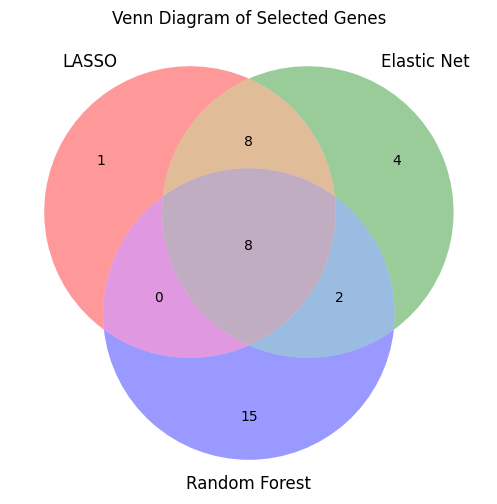

In [72]:
#  Define gene sets 
# Define gene sets
lasso_genes = set(intersected_df['Gene'])
enet_genes = set(intersected_df_EN['Gene'])

rf_genes = set(['ZBTB20', 'MYADM', 'SPEN', 'PDGFRA', 'TCF4', 'GOLGA7', 
                'CXCL14', 'ADAMDEC1', 'FN1', 'HBB', 'CCDC80', 'AXL', 'MS4A7',
                'FBLN1', 'CUTALP', 'OAT', 'GPR155', 'ZNF331', 'CRIP2', 'ZNF830',
                'FHL1', 'AHNAK', 'ACTA2', 'NBAS', 'RUNX1T1'])

# 3. Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn3_unweighted(
    [lasso_genes, enet_genes, rf_genes],
    set_labels=('LASSO', 'Elastic Net', 'Random Forest')
)
plt.title("Venn Diagram of Selected Genes")
plt.savefig("Venn_RNA_SEQ")
plt.show()

In [58]:
print (lasso_genes)

{'OGT', 'SPEN', 'HAPLN1', 'SLC17A9', 'IGF1', 'CLEC10A', 'OAT', 'PDIK1L', 'ZBTB20', 'SGSM2', 'FBLN1', 'RILPL2', 'SLC7A6OS', 'ADAMDEC1', 'HOOK3', 'UTRN', 'CXCL14', 'FHL1', 'AHNAK', 'MAP9', 'OLFML3', 'CRISPLD2', 'CH25H', 'GPR155', 'CALD1', 'INS-IGF2', 'P2RY14', 'ITPR2', 'H1-2', 'UTP6', 'PTN', 'JAZF1', 'FZD1', 'AXL', 'ZNF830', 'TMEM47', 'SCARA5', 'PLAAT2', 'SLC9A3', 'SYNM', 'MYADM', 'FTX', 'TTLL7', 'NPIPB5', 'EFEMP1', 'PP7080', 'COL4A1', 'GPC6', 'FOLR2', 'PRNP', 'TCF4'}


In [59]:
print (enet_genes)

{'OGT', 'SPEN', 'HAPLN1', 'SLC17A9', 'IGF1', 'CLEC10A', 'TACC1', 'OAT', 'PDIK1L', 'ZBTB20', 'SGSM2', 'FBLN1', 'PTGS2', 'RILPL2', 'SLC7A6OS', 'ADAMDEC1', 'HOOK3', 'UTRN', 'CXCL14', 'FHL1', 'AHNAK', 'MAP9', 'OLFML3', 'CRISPLD2', 'CH25H', 'GPR155', 'CALD1', 'INS-IGF2', 'P2RY14', 'ITPR2', 'DHX16', 'H1-2', 'CCDC80', 'UTP6', 'PTN', 'JAZF1', 'LIX1L', 'FZD1', 'AXL', 'ZNF830', 'TMEM47', 'PKDCC', 'SCARA5', 'PLAAT2', 'SLC9A3', 'SYNM', 'MYADM', 'FTX', 'EFEMP1', 'NPIPB5', 'DCN', 'PP7080', 'COL4A1', 'GPC6', 'FOLR2', 'PRNP', 'TCF4'}


In [141]:
# Find the intersection of all three sets
intersected_genes = lasso_genes & enet_genes & rf_genes

# Show result
print("Intersected genes across LASSO, EN, and RF:")
print(sorted(intersected_genes))

Intersected genes across LASSO, EN, and RF:
['CXCL14', 'FHL1', 'MYADM', 'OAT', 'SPEN', 'TCF4', 'ZBTB20', 'ZNF830']


In [143]:
# union genes of all models 

union_genes = lasso_genes | enet_genes | rf_genes


In [145]:
print(union_genes)

{'FBLN1', 'CXCL14', 'FHL1', 'RUNX1T1', 'HAPLN1', 'FOLR2', 'GPC6', 'NBAS', 'AXL', 'CCDC80', 'CUTALP', 'TACC1', 'FN1', 'JAZF1', 'ZBTB20', 'OGT', 'PP7080', 'UTRN', 'HBB', 'GPR155', 'MYADM', 'PDGFRA', 'SLC9A3', 'GOLGA7', 'MS4A7', 'ZNF331', 'P2RY14', 'AHNAK', 'ADAMDEC1', 'CRISPLD2', 'ZNF830', 'INS-IGF2', 'OAT', 'TCF4', 'ACTA2', 'CRIP2', 'SPEN', 'TTLL7'}


In [ ]:
{'OGT', 'SPEN', 'HAPLN1', 'IGF1', 'CLEC10A', 'OAT', 'SGSM2', 'FBLN1', 'CRIP2', 'NBAS', 'ADAMDEC1',
 'MS4A7', 'HOOK3', 'UTRN', 'CXCL14', 'AHNAK', 'MAP9', 'OLFML3', 'CH25H', 'INS-IGF2', 'P2RY14', 'H1-2',
 'ACTA2', 'CCDC80', 'JAZF1', 'LIX1L', 'ZNF830', 'SCARA5', 'SLC9A3', 'FTX', 'EFEMP1', 'NPIPB5', 'DCN',
 'COL4A1', 'PDGFRA', 'GPC6', 'PTGS2', 'PRNP', 'SLC17A9', 'TACC1', 'PDIK1L', 'ZBTB20', 'GOLGA7', 'RILPL2',
 'SLC7A6OS', 'FHL1', 'CRISPLD2', 'GPR155', 'CALD1', 'CUTALP', 'HBB', 'ITPR2', 'FN1', 'DHX16', 'RUNX1T1', 
 'UTP6', 'PTN', 'FZD1', 'AXL', 'TMEM47', 'PKDCC', 'PLAAT2', 'SYNM', 'MYADM', 'TTLL7', 'PP7080', 'ZNF331', 
 'FOLR2', 'TCF4'}

In [63]:
with open("union_genes.txt", "w") as f:
    for gene in union_genes:
        f.write(f"{gene}\n")

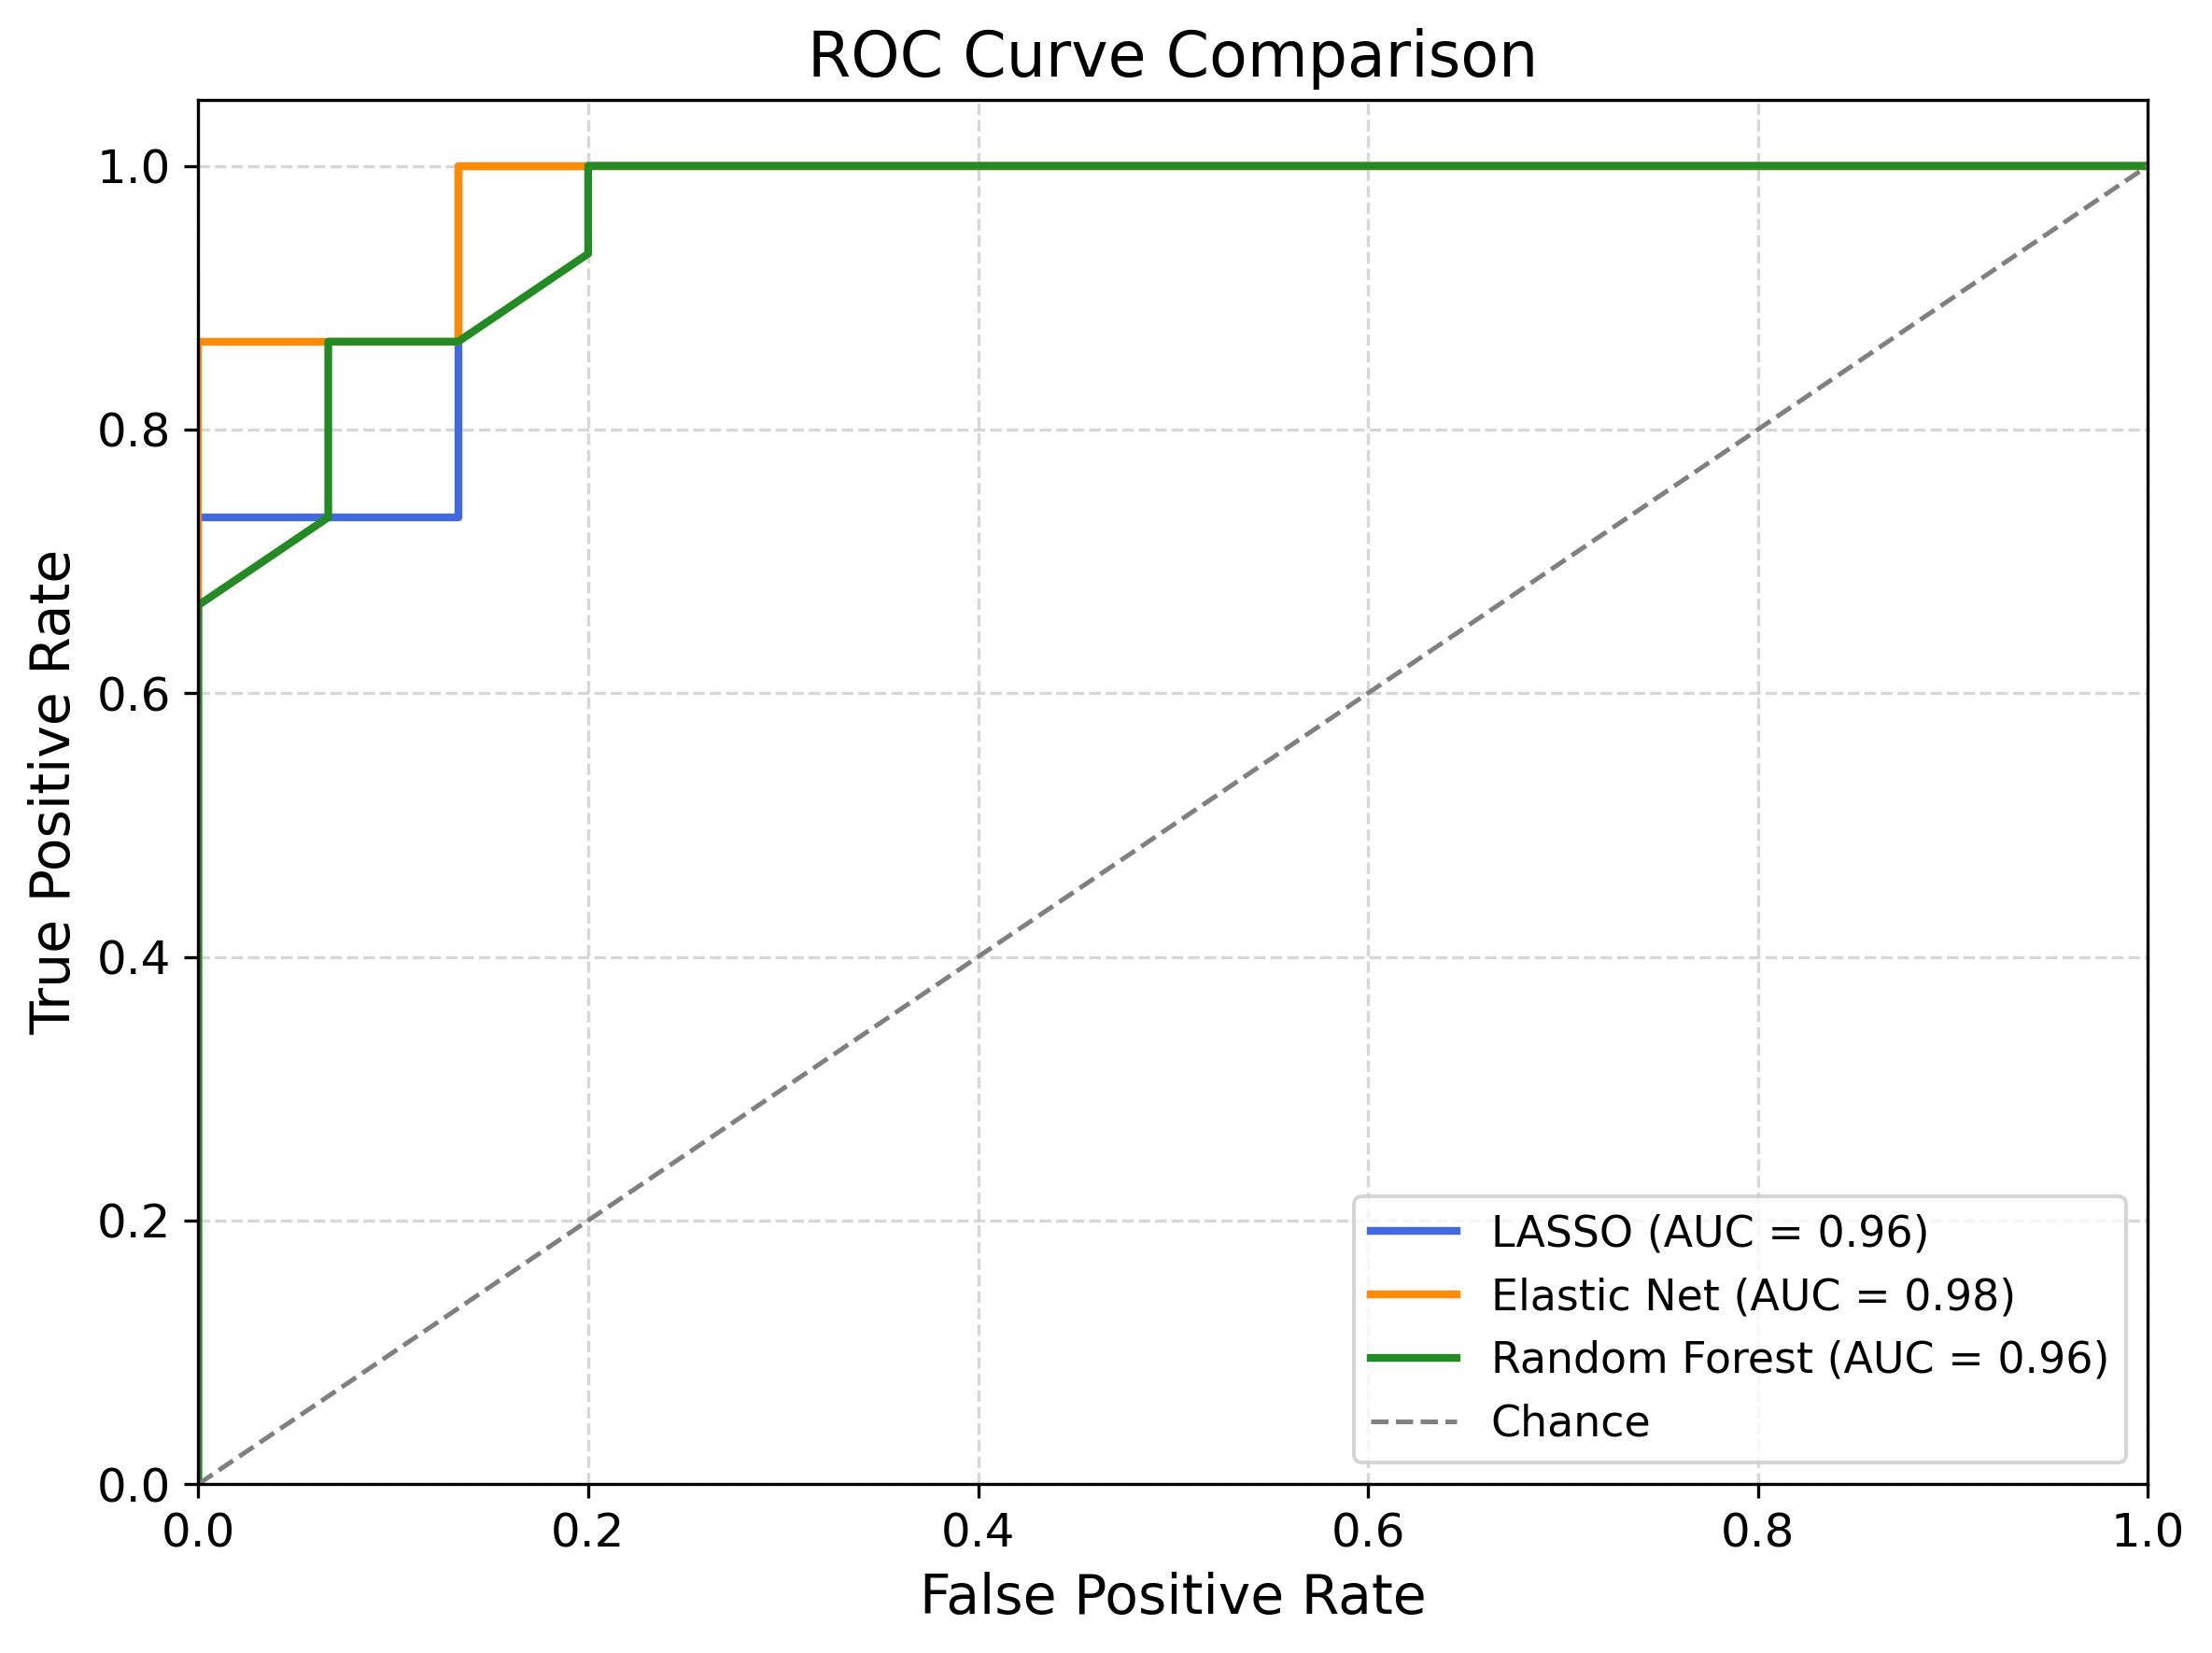

In [137]:

# Compute ROC curve and AUC for each model
fpr_lasso, tpr_lasso, _ = roc_curve(y_true_LA, y_pred_prob_LA)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

fpr_en, tpr_en, _ = roc_curve(y_true_EN, y_pred_prob_EN)
roc_auc_en = auc(fpr_en, tpr_en)

fpr_rf, tpr_rf, _ = roc_curve(y_true_all_RF, y_prob_all_RF)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot setup
plt.figure(figsize=(8, 6), dpi=300)

# Plot ROC curves with distinct styles
plt.plot(fpr_lasso, tpr_lasso, color='royalblue', linewidth=2, label=f'LASSO (AUC = {roc_auc_lasso:.2f})')
plt.plot(fpr_en, tpr_en, color='darkorange', linewidth=2, label=f'Elastic Net (AUC = {roc_auc_en:.2f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.2, label='Chance')

# Axis settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)

# Legend
plt.legend(loc='lower right', fontsize=11, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Save and show
plt.tight_layout()
plt.savefig("ROC_rna_clean.png", dpi=300)
plt.show()


In [139]:
# LASSO
pd.DataFrame({"y_true": y_true_LA, "y_prob": y_pred_prob_LA}).to_csv("lasso_predictions.csv", index=False)

# Elastic Net
pd.DataFrame({"y_true": y_true_EN, "y_prob": y_pred_prob_EN}).to_csv("en_predictions.csv", index=False)

# Random Forest
pd.DataFrame({"y_true": y_true_all_RF, "y_prob": y_prob_all_RF}).to_csv("rf_predictions.csv", index=False)


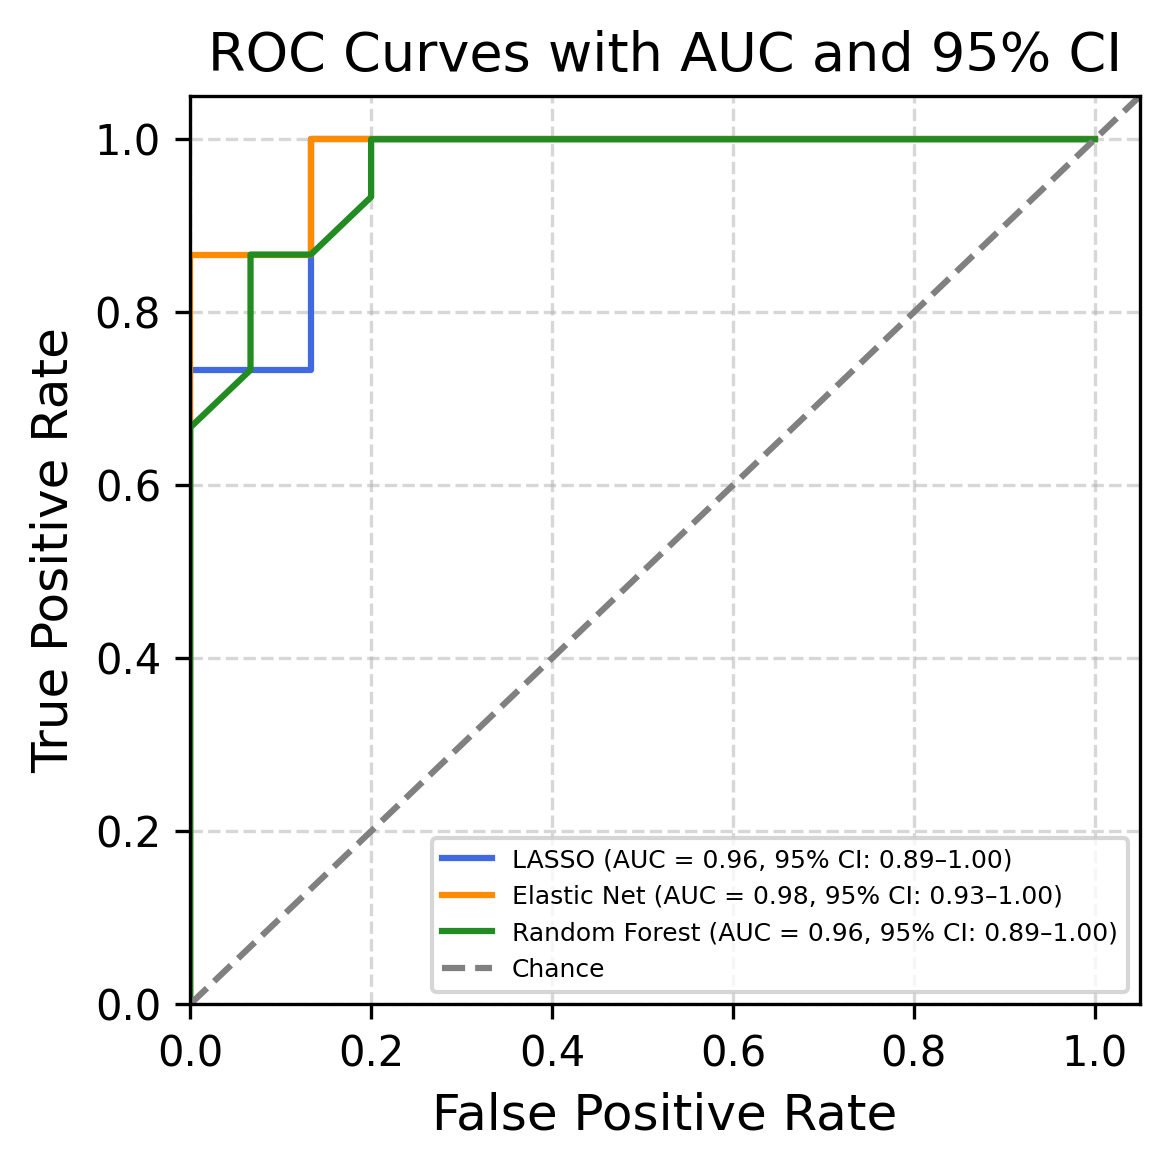

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d

def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    aucs = []

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        auc = roc_auc_score(y_true[indices], y_score[indices])
        aucs.append(auc)

    aucs = np.array(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    mean_auc = roc_auc_score(y_true, y_score)

    return mean_auc, lower, upper

# === Get true ROC + CI for all models ===
# LASSO
fpr_lasso, tpr_lasso, _ = roc_curve(y_true_LA, y_pred_prob_LA)
auc_lasso, ci_lower_lasso, ci_upper_lasso = bootstrap_auc_ci(y_true_LA, y_pred_prob_LA)

# EN
fpr_en, tpr_en, _ = roc_curve(y_true_EN, y_pred_prob_EN)
auc_en, ci_lower_en, ci_upper_en = bootstrap_auc_ci(y_true_EN, y_pred_prob_EN)

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_true_all_RF, y_prob_all_RF)
auc_rf, ci_lower_rf, ci_upper_rf = bootstrap_auc_ci(y_true_all_RF, y_prob_all_RF)

# === Plot setup ===
plt.figure(figsize=(4, 4), dpi=300)

# Plot true ROC curves only
plt.plot(fpr_lasso, tpr_lasso, color='royalblue', linewidth=1.5,
         label=f'LASSO (AUC = {auc_lasso:.2f}, 95% CI: {ci_lower_lasso:.2f}–{ci_upper_lasso:.2f})')
plt.plot(fpr_en, tpr_en, color='darkorange', linewidth=1.5,
         label=f'Elastic Net (AUC = {auc_en:.2f}, 95% CI: {ci_lower_en:.2f}–{ci_upper_en:.2f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', linewidth=1.5,
         label=f'Random Forest (AUC = {auc_rf:.2f}, 95% CI: {ci_lower_rf:.2f}–{ci_upper_rf:.2f})')

# Chance line
plt.plot([0, 1.05], [0, 1.05], linestyle='--', color='gray', label='Chance')

# Style
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves with AUC and 95% CI', fontsize=13)
plt.legend(loc='lower right', fontsize=6, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("RNA_ROC_FINAL.png", dpi=300)
plt.show()


## Violin / box plot for Significant 13 genes

In [147]:
# box plot or violin plot with p-values 

selected_genes_all = ['CXCL14', 'FHL1', 'MYADM', 'OAT', 'SPEN', 'TCF4', 'ZBTB20', 'ZNF830']
X_log_selected = X_log[selected_genes_all]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

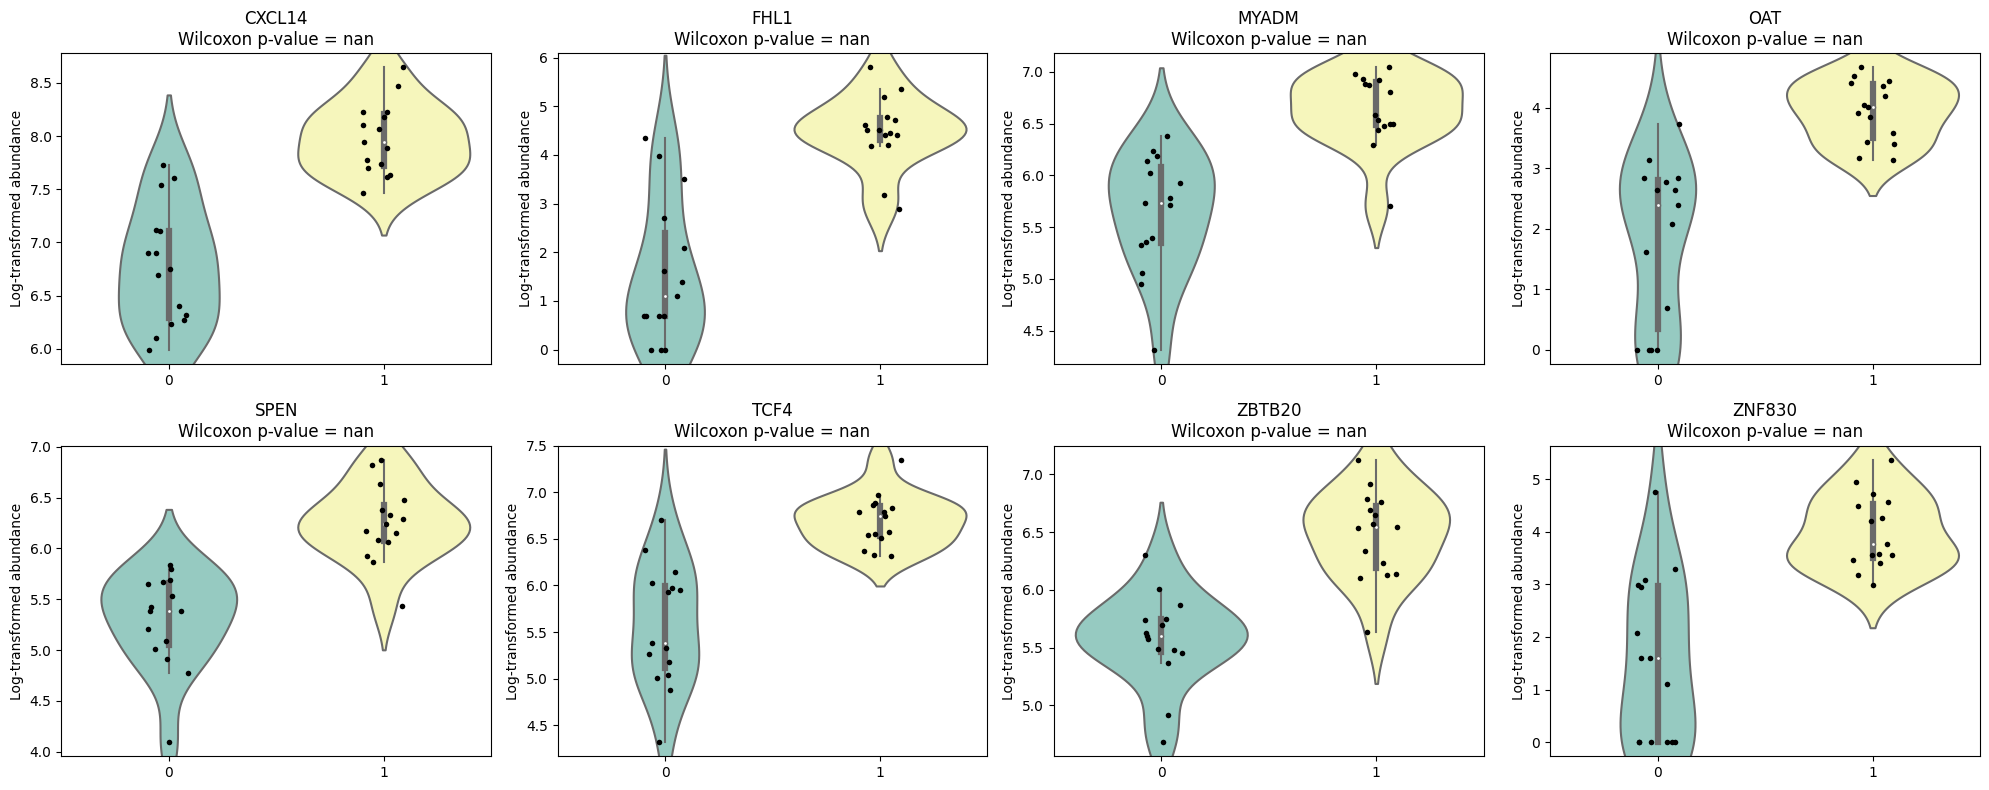

In [149]:
# First create a DataFrame combining features and labels
df_plot = X_log_selected.copy()
df_plot['Group'] = y  # add your treatment labels


# Initialize figure
n = len(selected_genes_all)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, metabolite in enumerate(selected_genes_all):
    plt.subplot(rows, cols, i+1)
    
    # Extract paired data
    before = df_plot[df_plot['Group'] == 'Baseline'][metabolite].values
    after = df_plot[df_plot['Group'] == 'Week 4'][metabolite].values
    
    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)
    
    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot, palette="Set3")
    sns.stripplot(x='Group', y=metabolite, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p-value = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('Log-transformed abundance')

plt.tight_layout()
plt.savefig('violin_plot_RNA.png')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

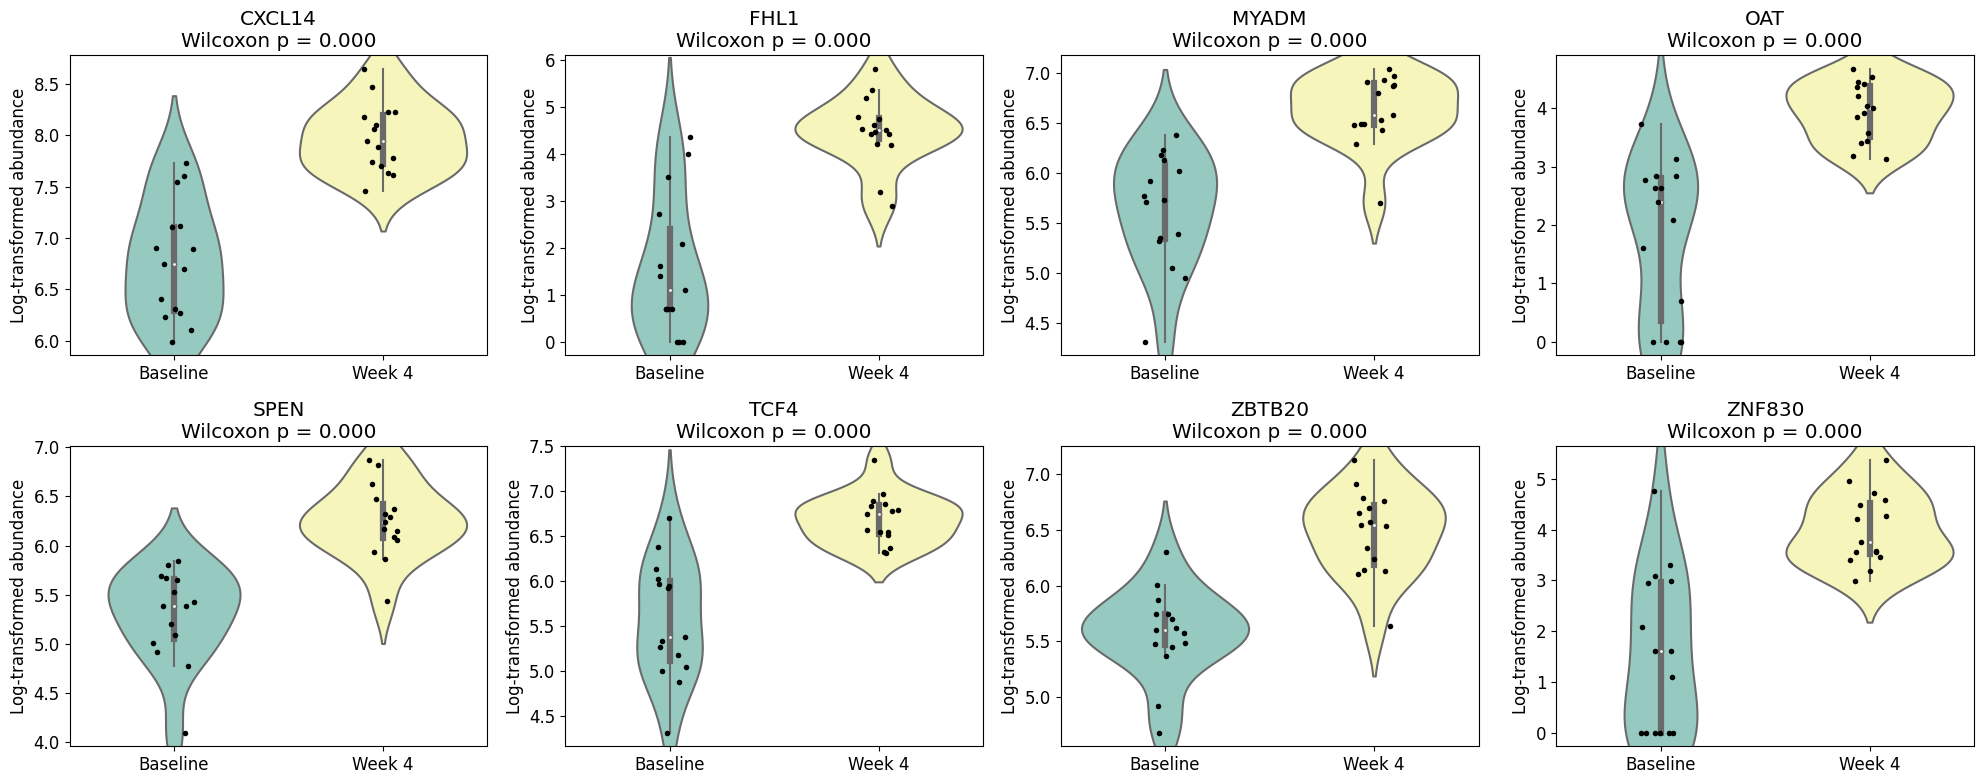

In [194]:
# First create a DataFrame combining features and labels
df_plot = X_log_selected.copy()
df_plot['Group'] = y  # Add treatment labels: 'Baseline' and 'Week 4'

# Set layout
cols = 4
rows = 2

plt.figure(figsize=(cols * 5, rows * 4))
plt.rcParams.update({'font.size': 12})
for i, metabolite in enumerate(selected_genes_all):
    plt.subplot(rows, cols, i + 1)

    # Extract paired data
    before = df_plot[df_plot['Group'] == 'Baseline'][metabolite].values
    after = df_plot[df_plot['Group'] == 'Week 4'][metabolite].values

    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)

    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot, palette="Set3")
    sns.stripplot(x='Group', y=metabolite, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('Log-transformed abundance')

plt.tight_layout()
plt.savefig('violin_plot_RNA.png', dpi=300)
plt.show()
